<a href="https://colab.research.google.com/github/andreacohen7/healthcare/blob/main/Stroke_Predictions_with_Visualizations%2C_Modeling%2C_and_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Predictions
- Andrea Cohen
- 01.25.23

## Task
  - To predict whether a patient is likely to have a stroke based on the input parameters like gender, age, various diseases, and smoking status.

## Data
Stroke Prediction Dataset.  
11 clinical features for predicting stroke events
- Source --
  - https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download
- Context --
  - According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.  
  - This dataset is used to predict whether a patient is likely to have a stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relevent information about the patient.


## Data Dictionary

Variable Name	| Description
---| ---
id |	unique identifier
gender |	"Male", "Female" or "Other"
age |	age of the patient
hypertension |	0 if the patient doesn't have hypertension, 1 if the patient has hypertension
heart_disease |	0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
ever_married |	"No" or "Yes"
work_type |	"children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
Residence_type |	"Rural" or "Urban"
avg_glucose_level |	average glucose level in blood
bmi |	body mass index
smoking_status |	"formerly smoked", "never smoked", "smokes" or "Unknown"*
stroke |	1 if the patient had a stroke or 0 if not

 *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

## Preliminary Steps

### Mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(display='diagram')

## Load and inspect the data

### Load the dataset

In [3]:
# load the dataset and check for unnecessary columns
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv', index_col = 0)
display(df.head())
display(df.info())

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


None

  - There are no unnecessary columns.

### Inspect the data

In [4]:
df.shape

(5110, 11)

  - There are 5110 rows and 11 columns.

In [5]:
# check datatypes and ensure that they match the data dictionary
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

  - gender, ever_married, work_type, Residence_type, and smoking_status are all datatype object
  - age, avg_glucose_level, and bmi are all datatype float64
  - hypertension, heart_disease, and stroke are all datatype int64
  - All datatypes are consistent with the data dictionary.

In [6]:
# check for outliers and obvious errors
display(df.describe(include='number'))
display(df.describe(exclude='number'))

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


  - There are no obvious outliers or errors in the data.

In [7]:
# check for duplicated rows
df.duplicated().sum()

0

  - There are 0 duplicates.

In [8]:
# check for missing values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

  - There are 201 missing values in bmi.
  - Options:
    - Dropping rows was not a good option because 3.93% of rows are missing data--too many (>2%) to just eliminate.  
    - Dropping columns was not a good option because bmi might be an important property for predicting a stroke. Also, <50% of the data are missing, too little to just eliminate.  
    - Creating a new category was not a good option because the data are type float instead of type object.  
    - Imputing missing values is a great option because the average (mean) value would likely be closest to the correct value that is missing.
  - Mean imputation will be performed on a copy of the dataset for machine learning--this imputation will be performed within a pipeline in order to prevent data leakage.

In [9]:
# check the categorical data for inconsistencies
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index
for col in str_cols:
  print(f'Column= {col}')
  print(df[col].value_counts())
  print(' ')

Column= gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
 
Column= ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64
 
Column= work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
 
Column= Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
 
Column= smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
 


  - There are no inconsistencies in categorical data.
  - For machine learning, categorical data will be one-hot encoded.

In [10]:
# check the balance of the target class
df['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

  - The target classes are severely imbalanced (95.13% of the samples did not have a stroke and 4.87% of the samples had a stroke).

## Univariate visualizations

### Graph to view the distribution of the target class

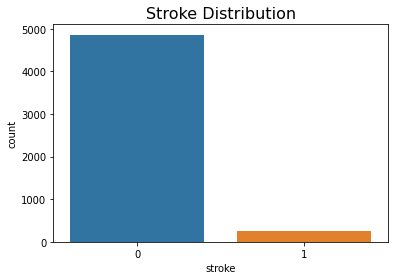

In [11]:
sns.countplot(data = df, x = 'stroke')
plt.title('Stroke Distribution', fontsize = 16);
plt.savefig('Stroke Distribution.png', dpi = 300)

  - The target class is significantly imbalanced--there were fewer strokes than not.

### Graphs to view patient characteristics

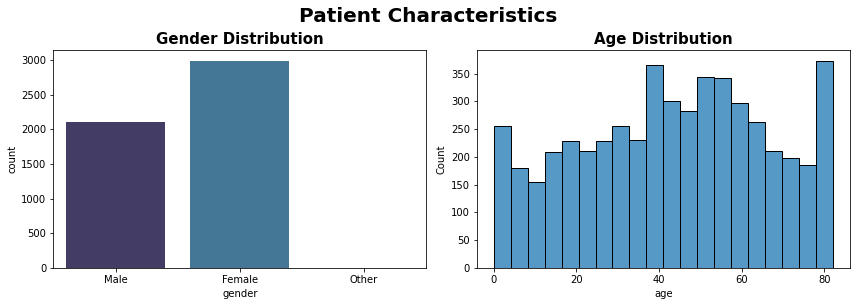

In [12]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))
sns.countplot(data = df, x = 'gender',  palette = 'mako', ax = axes[0])
axes[0].set_title('Gender Distribution', fontsize = 15, fontweight = 'bold')
sns.histplot(data = df, x = 'age', ax = axes[1])
axes[1].set_title('Age Distribution', fontsize = 15, fontweight = 'bold')
fig.suptitle('Patient Characteristics', fontsize = 20, fontweight = 'bold', y = 1.05)
fig.tight_layout()

  - There were siginificantly more female patients than male or other patients.
  - There was no specific skew to the age distribution of patients, although there were spikes in the number of patients younger than 4, 37-41, 52-58, and over 78 years.

### Graphs to view behavioral characteristics

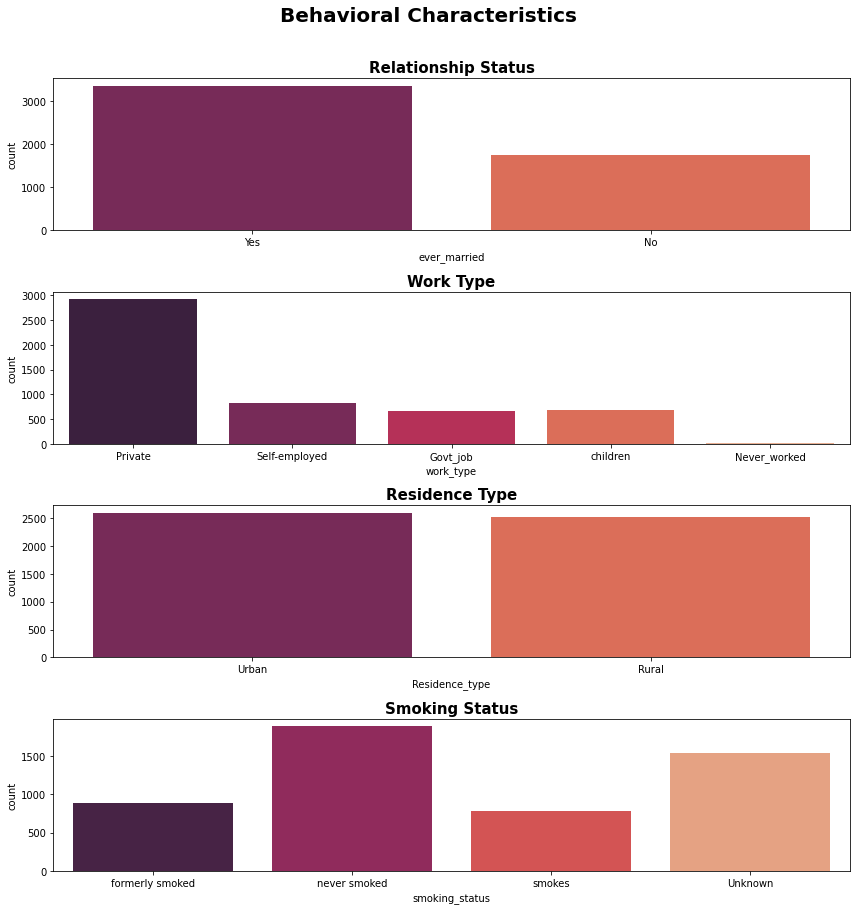

In [13]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, figsize = (12, 12))
sns.countplot(data = df, x = 'ever_married', palette = 'rocket',  ax = axes[0])
axes[0].set_title('Relationship Status', fontsize = 15, fontweight = 'bold')
sns.countplot(data = df, x = 'work_type', palette = 'rocket', ax = axes[1])
axes[1].set_title('Work Type', fontsize = 15, fontweight = 'bold')
sns.countplot(data = df, x = 'Residence_type', palette = 'rocket', ax = axes[2])
axes[2].set_title('Residence Type', fontsize = 15, fontweight = 'bold')
sns.countplot(data = df, x = 'smoking_status', palette = 'rocket', ax = axes[3])
axes[3].set_title('Smoking Status', fontsize = 15, fontweight = 'bold')
fig.suptitle('Behavioral Characteristics', fontsize = 20, fontweight = 'bold', y = 1.05)
fig.tight_layout()
plt.savefig('Behavioral Characteristics.png', dpi = 300)

  - The majority of patients were married.
  - The majority of patients were privately employed.
  - The distribution of residence types (urban and rural) was even.
  - The majority of patients had never smoked or their smoking status was unknown.

### Graphs to view medical characteristics

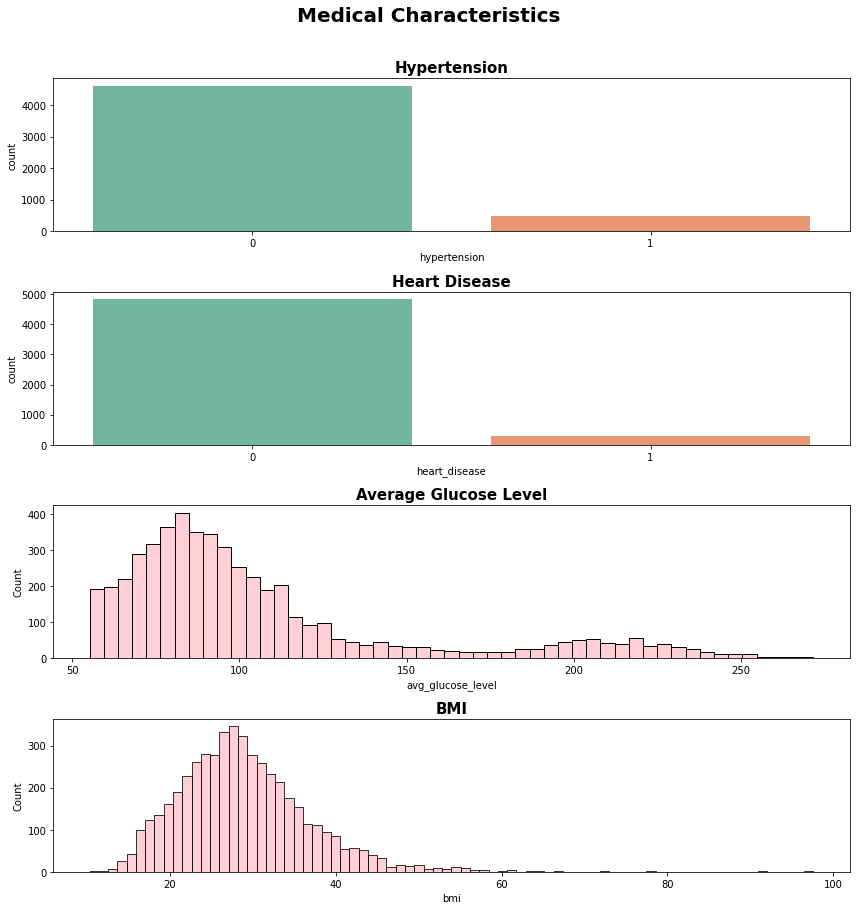

In [15]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, figsize = (12, 12))
sns.countplot(data = df, x = 'hypertension', palette = 'Set2',  ax = axes[0])
axes[0].set_title('Hypertension', fontsize = 15, fontweight = 'bold')
sns.countplot(data = df, x = 'heart_disease', palette = 'Set2', ax = axes[1])
axes[1].set_title('Heart Disease', fontsize = 15, fontweight = 'bold')
sns.histplot(data = df, x = 'avg_glucose_level', color = 'pink', ax = axes[2])
axes[2].set_title('Average Glucose Level', fontsize = 15, fontweight = 'bold')
sns.histplot(data = df, x = 'bmi', color = 'pink', ax = axes[3])
axes[3].set_title('BMI', fontsize = 15, fontweight = 'bold')
fig.suptitle('Medical Characteristics', fontsize = 20, fontweight = 'bold', y = 1.05)
fig.tight_layout()
plt.savefig('Medical Characteristics.png', dpi = 300)

  - The distribution of hypertension is significantly unbalanced--the majority of patients did not have hypertension.
  - The distribution of heart disease is significantly unbalanced--the majority of patients did not have heart disease.
  - The distribution of glucose levels is right-skewed, with the majority of patients having lower average glucose levels.
  - The distribution of BMI is right skewed, with the majority of patients having lower BMI's.

### Boxplots to view outliers

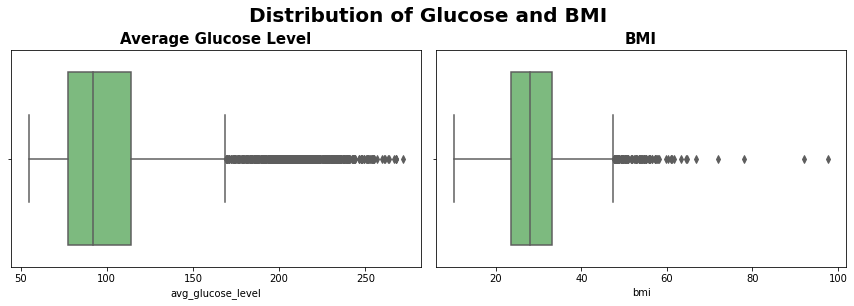

In [16]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))
sns.boxplot(data = df, x = 'avg_glucose_level', palette = 'Greens',  ax = axes[0])
axes[0].set_title('Average Glucose Level', fontsize = 15, fontweight = 'bold')
sns.boxplot(data = df, x = 'bmi', palette = 'Greens', ax = axes[1])
axes[1].set_title('BMI', fontsize = 15, fontweight = 'bold')
fig.suptitle('Distribution of Glucose and BMI', fontsize = 20, fontweight = 'bold', y = 1.05)
fig.tight_layout()

  - Both the Average Glucose Level and the BMI distributions have outliers above the maximum values.

## Multivariate Exploratory Visualizations

### Create a copy of the data for visualizations

In [17]:
vis_df = df.copy()

### Correlation Heatmap

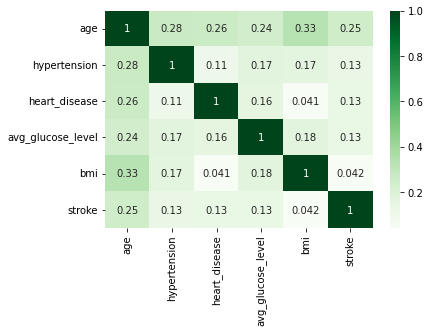

In [18]:
corr = vis_df.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True);

  - None of the features are correlated with the target or with each other.

### Do patient characteristics increase strokes?

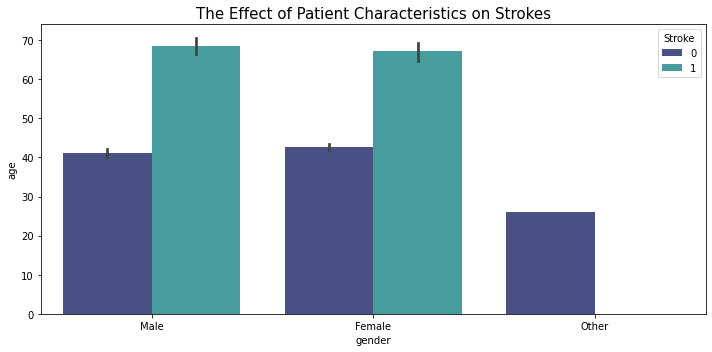

In [19]:
fig, axes = plt.subplots(figsize = (10, 5))
sns.barplot(data = vis_df, x = 'gender', y = 'age', hue = 'stroke', palette = 'mako')
plt.title('The Effect of Patient Characteristics on Strokes', fontsize = 15)
plt.legend(title = 'Stroke', loc = 1)
fig.tight_layout();

  - This barplot shows no relationship between the gender of the patient and strokes, regardless of age.  However, there is a relationship between the age of the patient and strokes--older patients have more strokes, regardless of their gender. 

### Do behavioral characteristics increase strokes?

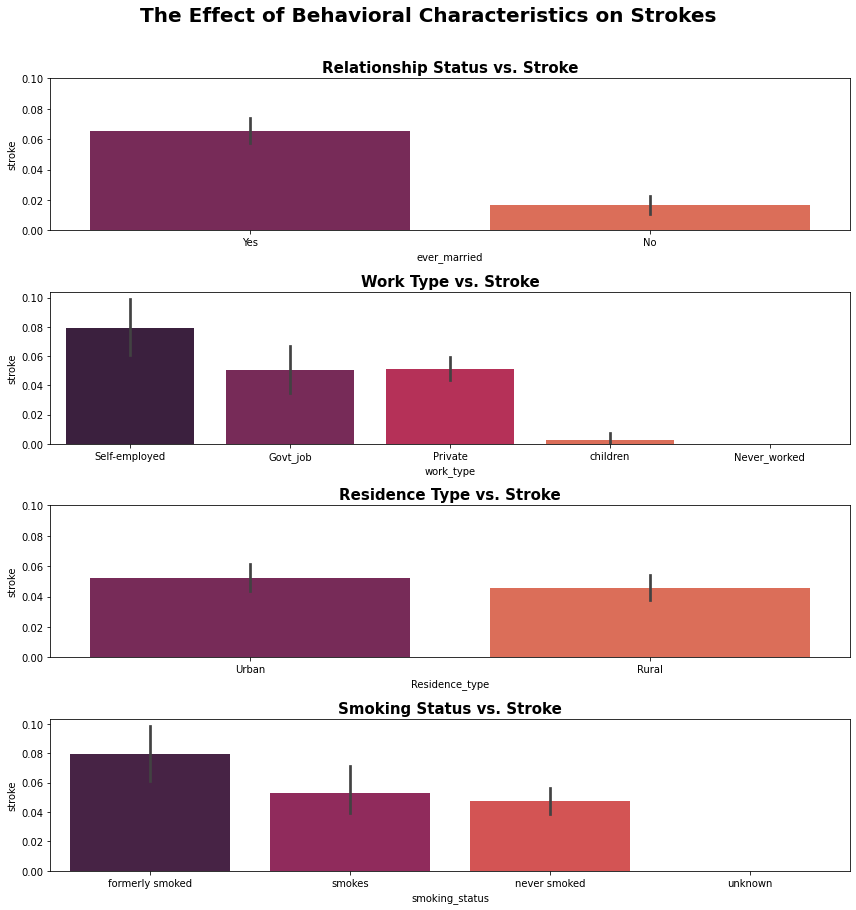

In [20]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, figsize = (12, 12))
sns.barplot(data = vis_df, x = 'ever_married', y = 'stroke',  palette = 'rocket', ax = axes[0])
axes[0].set_title('Relationship Status vs. Stroke', fontsize = 15, fontweight = 'bold')
axes[0].set_ylim(bottom=0.00, top=0.10)
sns.barplot(data = vis_df, x = 'work_type', y = 'stroke', order = ['Self-employed', 'Govt_job', 'Private', 'children', 'Never_worked'], palette = 'rocket', ax = axes[1])
axes[1].set_title('Work Type vs. Stroke', fontsize = 15, fontweight = 'bold')
sns.barplot(data = vis_df, x = 'Residence_type', y = 'stroke', palette = 'rocket', ax = axes[2])
axes[2].set_title('Residence Type vs. Stroke', fontsize = 15, fontweight = 'bold')
axes[2].set_ylim(bottom=0.00, top=0.10)
sns.barplot(data = vis_df, x = 'smoking_status', y = 'stroke', order = ['formerly smoked', 'smokes', 'never smoked', 'unknown'], palette = 'rocket', ax = axes[3])
axes[3].set_title('Smoking Status vs. Stroke', fontsize = 15, fontweight = 'bold')
fig.suptitle('The Effect of Behavioral Characteristics on Strokes', fontsize = 20, fontweight = 'bold', y = 1.05)
fig.tight_layout();
plt.savefig('The Effect of Behavioral Characteristics on Strokes.png', dpi = 300)

  - These barplots show that most behavioral characteristics increase strokes.
  - Mariage (even previous marriages) increases strokes.  
  - Work type (especially self-employed, government employees, and private employees) increases strokes.
  - Smoking status (especially former smokers) increases strokes.
  - There is no difference, though, in urban vs rural residences and strokes.

### Do medical characteristics increase strokes?

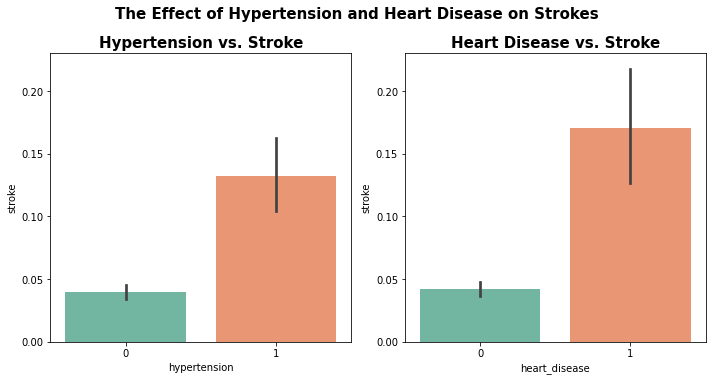

In [21]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5))
sns.barplot(data = vis_df, x = 'hypertension', y = 'stroke', palette = 'Set2', ax = axes[0])
axes[0].set_title('Hypertension vs. Stroke', fontsize = 15, fontweight = 'bold')
axes[0].set_ylim(bottom=0.000, top=0.230)
sns.barplot(data = vis_df, x = 'heart_disease', y = 'stroke', palette = 'Set2', ax = axes[1])
axes[1].set_title('Heart Disease vs. Stroke', fontsize = 15, fontweight = 'bold')
axes[1].set_ylim(bottom=0.000, top=0.230)
plt.suptitle('The Effect of Hypertension and Heart Disease on Strokes', fontweight = 'bold', fontsize = 15, y = 1.05)
fig.tight_layout();
plt.savefig('The Effect of Hypertension and Heart Disease on Strokes.png', dpi = 300)

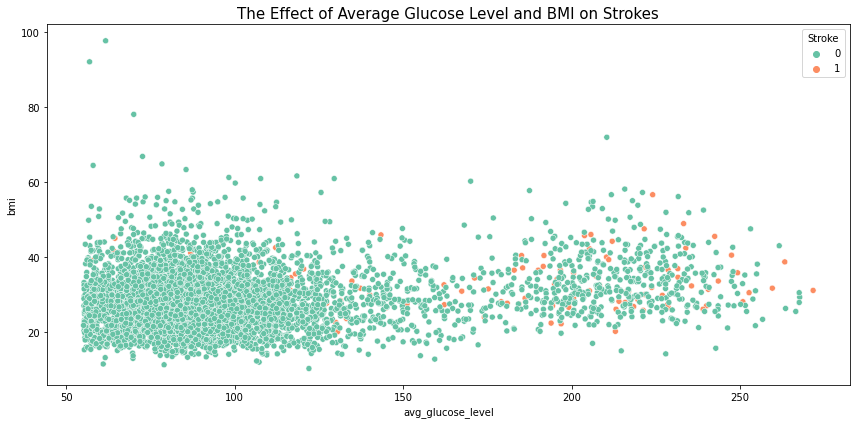

In [22]:
fig, axes = plt.subplots(figsize = (12, 6))
sns.scatterplot(data = vis_df, x = 'avg_glucose_level', y = 'bmi', hue = 'stroke', palette = 'Set2')
plt.title('The Effect of Average Glucose Level and BMI on Strokes', fontsize = 15)
plt.legend(title = 'Stroke', loc = 1)
fig.tight_layout();
plt.savefig('The Effect of Average Glucose Level and BMI on Strokes.png', dpi = 300)

  - These plots show that medical characteristics increase strokes.
  - The barplots show that hypertension and heart disease both increase strokes.
  - The scatterplot shows that the average glucose level increases strokes, but that BMI does not.

## Prepare the data for modeling

### Create a copy of the data for modeling

In [23]:
ml_df = df.copy()

### Separate the data into the features matrix (X) and target vector (y)

In [24]:
X = ml_df.drop(columns = 'stroke')
y = ml_df['stroke']

### Train test split the data (model validation)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

### Preprocessor

In [26]:
#instantiate the transformers to impute missing values and one-hot encode the categorical data
mean_imputer = SimpleImputer(strategy = 'mean')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
#create columnselectors for the numeric and categorical data
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
#combine the pipelines and columnselectors into tuples for the columntransformer
cat_tuple = (ohe, cat_selector)
num_tuple = (mean_imputer, num_selector)
#create the preprocessing columntransformer
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                ('simpleimputer', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca28b0>)])

## Random Forest Classifier

#### Default parameters

In [27]:
#instantiate the model
rf = RandomForestClassifier(random_state=42)
#create a model pipeline
rf_pipe = make_pipeline(preprocessor, rf)
#fit the model pipeline on the training data
rf_pipe.fit(X_train, y_train)
#evaluate the model's performance
print(rf_pipe.score(X_train, y_train))
print(rf_pipe.score(X_test, y_test))

1.0
0.94679186228482


#### Tuning hyperparameters using GridSearchCV

In [28]:
#choose hyperparameters for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                   ('simpleimputer', SimpleImputer(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca28b0>)])),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                     

In [29]:
#create a parameter grid dictionary
param_grid = {'randomforestclassifier__max_depth': [1, 5, 10],
              'randomforestclassifier__n_estimators': [50, 100, 200],
              'randomforestclassifier__min_samples_split':[2, 10, 100],
              'randomforestclassifier__class_weight':['balanced', 'balanced_subsample']}

In [30]:
#instantiate the GridSearchCV Class
rf_grid_search = GridSearchCV(rf_pipe, param_grid)

In [31]:
#fit the GridSearchCV on the Training Data
rf_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                                                        ('simpleimputer',
                                                                         SimpleImputer(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca28b0>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  'balanced_subsample'],
                         'randomforestclassifier__max_depth': [1, 5, 10],
                         'randomforestclassifier__min_samples_split': [2, 10,
                                                                       100],
                         'randomforestclassifier__n_estimators': [50, 100,
                                                                  200]})

In [32]:
#find the best parameters
print('Best Random Forest Classifier Parameters:')
print(rf_grid_search.best_params_)
best_model = rf_grid_search.best_estimator_
print(f'Accuracy of best Random Forest Classifier model is: {best_model.score(X_test, y_test)}')

Best Random Forest Classifier Parameters:
{'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 200}
Accuracy of best Random Forest Classifier model is: 0.918622848200313


In [33]:
#examine the best parameters found by the GridSearchCV object
param_grid2 = {'randomforestclassifier__max_depth': [9, 10, 11],
               'randomforestclassifier__n_estimators': [150, 200, 250],
               'randomforestclassifier__min_samples_split': [2, 3, 4],
               'randomforestclassifier__class_weight': ['balanced']}
rf_grid_search2 = GridSearchCV(rf_pipe, param_grid2)
rf_grid_search2.fit(X_train, y_train)
print(rf_grid_search2.best_params_)
best_rf = rf_grid_search2.best_estimator_
print(f'Accuracy of best Random Forest Classifier model is: {best_rf.score(X_test, y_test)}')

{'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 250}
Accuracy of best Random Forest Classifier model is: 0.931924882629108


In [34]:
#examine the best parameters found by the 2nd GridSearchCV object
param_grid3 = {'randomforestclassifier__max_depth': range(10, 20),
               'randomforestclassifier__n_estimators': [225, 250, 275, 300],
               'randomforestclassifier__min_samples_split': [2, 3],
               'randomforestclassifier__class_weight': ['balanced']}
rf_grid_search3 = GridSearchCV(rf_pipe, param_grid3)
rf_grid_search3.fit(X_train, y_train)
print(rf_grid_search3.best_params_)
best_rf3 = rf_grid_search3.best_estimator_
print(f'Accuracy of best-best Random Forest Classifier model is: {best_rf3.score(X_test, y_test)}')

{'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 17, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 275}
Accuracy of best-best Random Forest Classifier model is: 0.9507042253521126


### Final Random Forest Classifier Model Evaluation

In [35]:
#instantiate the tuned model
rf_tuned = RandomForestClassifier(max_depth=17, min_samples_split=2, n_estimators=275, class_weight = 'balanced', random_state=42)
#create the tuned model pipeline
rf_tuned_pipe = make_pipeline(preprocessor, rf_tuned)
#fit the tuned model pipeline on the training data
rf_tuned_pipe.fit(X_train, y_train)
#make predictions
train_preds_rf_tuned = rf_tuned_pipe.predict(X_train)
test_preds_rf_tuned = rf_tuned_pipe.predict(X_test)
#evaluate the model's performance
print(rf_tuned_pipe.score(X_train, y_train))
print(rf_tuned_pipe.score(X_test, y_test))

1.0
0.9507042253521126


  - Tuning the Random Forest Classifier increased the accuracy on the test set.

Random Forest Classifier Confusion Matrix


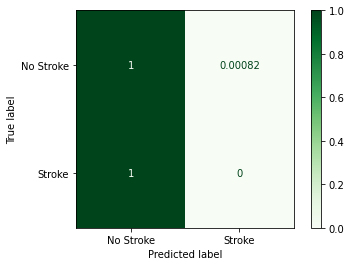

In [36]:
labels = ['No Stroke', 'Stroke']
print('Random Forest Classifier Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_rf_tuned, display_labels = labels, cmap = 'Greens', normalize = 'true');

  - The tuned Random Forest Classifier model successfully classified 100% of the no stroke samples but 0% of the stroke samples.

In [37]:
print('Random Forest Classifier Classification Report')
print(classification_report(y_test, test_preds_rf_tuned))

Random Forest Classifier Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



  - The tuned Random Forest Classifier model was 95% accurate for making correct predictions on the test set.
  - The tuned Random Forest Classifier model was 95% sensitive and 100% specific for predicting the no stroke class.
  - However, the tuned Random Forest Classifier model was 0% sensitive and 0% specific for predicting the stroke class.
  - The tuned Random Forest Classifier model had f1-scores of 97% for the no stroke class and, again, 0% for the stroke class.

The target class imbalance limits the model's predictions of the stroke class.

#### Random Forest Classifier with SMOTE

In [38]:
#instantiate SMOTE and RandomForestClassifier
smote = SMOTE(random_state=42)
rf_smote = RandomForestClassifier(random_state=42)
#create a model pipeline
rf_smote_pipe = make_sampler_pipeline(preprocessor, smote, rf_smote)
#fit the model pipeline on the training data
rf_smote_pipe.fit(X_train, y_train)
#evaluate the model's performance
print(rf_smote_pipe.score(X_train, y_train))
print(rf_smote_pipe.score(X_test, y_test))

0.9997390396659708
0.9428794992175273


#### Tuning hyperparameters using GridSearchCV

In [39]:
#choose hyperparameters for tuning
rf_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                   ('simpleimputer', SimpleImputer(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca28b0>)])),
  ('smote', SMOTE(random_state=42)),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x

In [40]:
#create a parameter grid dictionary
rf_smote_param_grid = {'randomforestclassifier__max_depth': [1, 5, 10],
              'randomforestclassifier__n_estimators': [50, 100, 200],
              'randomforestclassifier__min_samples_split':[2, 10, 100],
              'randomforestclassifier__class_weight':['balanced', 'balanced_subsample']}

In [41]:
#instantiate the GridSearchCV Class
rf_smote_grid_search = GridSearchCV(rf_smote_pipe, rf_smote_param_grid)

In [42]:
#fit the GridSearchCV on the Training Data
rf_smote_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                                                        ('simpleimputer',
                                                                         SimpleImputer(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca28b0>)])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  'balanced_subsample'],
                         'randomforestclassifier__max_depth': [1, 5, 10],
                         'randomforestclassifier__min_samples_split': [2, 10,
                                                                       100],
                         'randomforestclassifier__n_estimators': [50, 100,
                                                                  200]})

In [43]:
#find the best parameters
print('Best Random Forest Classifier with SMOTE Parameters:')
print(rf_smote_grid_search.best_params_)
best_rf_smote_model = rf_smote_grid_search.best_estimator_
print(f'Accuracy of best Random Forest Classifier with SMOTE model is: {best_rf_smote_model.score(X_test, y_test)}')

Best Random Forest Classifier with SMOTE Parameters:
{'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Accuracy of best Random Forest Classifier with SMOTE model is: 0.9491392801251957


In [44]:
#examine the best parameters found by the GridSearchCV object
rf_smote_param_grid2 = {'randomforestclassifier__max_depth': [9, 10, 11],
               'randomforestclassifier__n_estimators': [100, 150, 200],
               'randomforestclassifier__min_samples_split': [2, 5, 10],
               'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample']}
rf_smote_grid_search2 = GridSearchCV(rf_smote_pipe, rf_smote_param_grid2)
rf_smote_grid_search2.fit(X_train, y_train)
print(rf_smote_grid_search2.best_params_)
best_rf_smote = rf_smote_grid_search2.best_estimator_
print(f'Accuracy of best Random Forest Classifier with SMOTE model is: {best_rf_smote.score(X_test, y_test)}')

{'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Accuracy of best Random Forest Classifier with SMOTE model is: 0.9491392801251957


In [45]:
#examine the best parameters found by the 2nd GridSearchCV object
rf_smote_param_grid3 = {'randomforestclassifier__max_depth': [10],
               'randomforestclassifier__n_estimators': [100],
               'randomforestclassifier__min_samples_split': [2, 3, 4],
               'randomforestclassifier__class_weight': ['balanced_subsample']}
rf_smote_grid_search3 = GridSearchCV(rf_smote_pipe, rf_smote_param_grid3)
rf_smote_grid_search3.fit(X_train, y_train)
print(rf_smote_grid_search3.best_params_)
best_rf_smote_3 = rf_smote_grid_search3.best_estimator_
print(f'Accuracy of best-best Random Forest Classifier with SMOTE model is: {best_rf_smote_3.score(X_test, y_test)}')

{'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Accuracy of best-best Random Forest Classifier with SMOTE model is: 0.9491392801251957


### Final Random Forest Classifier with SMOTE Model Evaluation

In [46]:
#instantiate the tuned model
rf_smote_tuned = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=100, class_weight = 'balanced_subsample', random_state=42)
#create the tuned model pipeline
rf_smote_tuned_pipe = make_sampler_pipeline(preprocessor, smote, rf_smote_tuned)
#fit the tuned model pipeline on the training data
rf_smote_tuned_pipe.fit(X_train, y_train)
#make predictions
train_preds_rf_smote_tuned = rf_smote_tuned_pipe.predict(X_train)
test_preds_rf_smote_tuned = rf_smote_tuned_pipe.predict(X_test)
#evaluate the model's performance
print(rf_smote_tuned_pipe.score(X_train, y_train))
print(rf_smote_tuned_pipe.score(X_test, y_test))

0.964509394572025
0.9491392801251957


  - Tuning the Random Forest Classifier with SMOTE increased the accuracy on the test set.

Random Forest Classifier with SMOTE Confusion Matrix


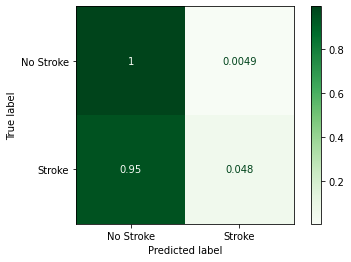

In [47]:
print('Random Forest Classifier with SMOTE Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_rf_smote_tuned, display_labels = labels, cmap = 'Greens', normalize = 'true');

  - The tuned Random Forest Classifier with SMOTE successfully classified 100% of the no stroke samples and 4.8% of the stroke samples.

In [48]:
print('Random Forest Classifier with SMOTE Classification Report')
print(classification_report(y_test, test_preds_rf_smote_tuned))

Random Forest Classifier with SMOTE Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1216
           1       0.33      0.05      0.08        62

    accuracy                           0.95      1278
   macro avg       0.64      0.52      0.53      1278
weighted avg       0.92      0.95      0.93      1278



  - The tuned Random Forest Classifier with SMOTE model was 95% accurate for making correct predictions on the test set (which was the same as the tuned Random Forest Classifier without SMOTE model).
  - The tuned Random Forest Classifier with SMOTE model was 95% sensitive and 100% specific for predicting the no stroke class (which was the same as the tuned Random Forest Classifier without SMOTE model).
  - The tuned Random Forest Classifier with SMOTE model was 33% sensitive and 5% specific for predicting the stroke class (which was better than the tuned Random Forest Classifier without SMOTE model).
  - The tuned Random Forest Classifier with SMOTE model had f1-scores of 97% for the no stroke class (which was the same as the tuned Random Forest Classifier without SMOTE model), but 8% for the stroke class (which was better than the Random Forest Classifier without SMOTE model.

Using SMOTE and tuning the hyperparameters helped the Random Forest Classifier predict the stroke class.

## Logistic Regression

#### Default parameters

In [49]:
#instantiate the model and the standard scaler
lr = LogisticRegression(random_state=42)
scaler = StandardScaler()
#create a model pipeline
lr_pipe = make_pipeline(preprocessor, scaler, lr)
#fit the model pipeline on the training data
lr_pipe.fit(X_train, y_train)
#evaluate the model's performance
print(lr_pipe.score(X_train, y_train))
print(lr_pipe.score(X_test, y_test))

0.9512004175365344
0.9522691705790297


#### Tuning hyperparameters using GridSearchCV

In [50]:
#choose hyperparameters for tuning
lr_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                   ('simpleimputer', SimpleImputer(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca28b0>)])),
  ('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f26f

In [51]:
#create a parameter grid dictionary
lr_param_grid = {'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'logisticregression__max_iter': [10000],
              'logisticregression__solver': ['liblinear', 'saga'],
              'logisticregression__penalty': ['l1'],
              'logisticregression__class_weight': ['balanced', None]}

In [52]:
#instantiate the GridSearchCV Class
lr_grid_search = GridSearchCV(lr_pipe, lr_param_grid)

In [53]:
#fit the GridSearchCV on the Training Data
lr_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                                                        ('simpleimputer',
                                                                         SimpleImputer(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fac...
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000],
                         'logisticregression__class_weight': ['balanced', None],
                         'logisticregression__max_iter': [10000],
                         'logisticregression__penalty': ['l1'],
                         'logisticregression__solver': ['liblinear', 'saga']})

In [54]:
#find the best parameters
print('Best Logistic Regression Model Parameters:')
print(lr_grid_search.best_params_)
best_lr_model = lr_grid_search.best_estimator_
print(f'Accuracy of best Logistic Regression Model is: {best_lr_model.score(X_test, y_test)}')

Best Logistic Regression Model Parameters:
{'logisticregression__C': 0.0001, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Accuracy of best Logistic Regression Model is: 0.9514866979655712


### Final Logistic Regression Model Evaluation

In [55]:
#instantiate the tuned model
lr_tuned = LogisticRegression(C=.0001, max_iter=10000, solver='liblinear', penalty='l1', class_weight = 'balanced', random_state=42)
#create the tuned model pipeline
lr_tuned_pipe = make_pipeline(preprocessor, scaler, lr_tuned)
#fit the tuned model pipeline on the training data
lr_tuned_pipe.fit(X_train, y_train)
#make predictions
train_preds_lr_tuned = lr_tuned_pipe.predict(X_train)
test_preds_lr_tuned = lr_tuned_pipe.predict(X_test)
#evaluate the model's performance
print(lr_tuned_pipe.score(X_train, y_train))
print(lr_tuned_pipe.score(X_test, y_test))

0.9512004175365344
0.9514866979655712


  - Tuning the Logistic Regression model decreased the accuracy on the test set.

Logistic Regression Model Confusion Matrix


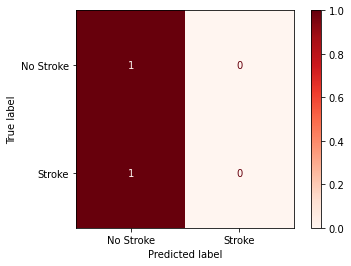

In [56]:
print('Logistic Regression Model Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_lr_tuned, display_labels = labels, cmap = 'Reds', normalize = 'true');

  - The tuned Logistic Regression Model successfully classified 100% of the no stroke samples but 0% of the stroke samples.

In [57]:
print('Logistic Regression Model Classification Report')
print(classification_report(y_test, test_preds_lr_tuned))

Logistic Regression Model Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  - The tuned Logistic Regression Model was 95% accurate for making correct predictions on the test set.
  - The tuned Logistic Regression Model was 95% sensitive and 100% specific for predicting the no stroke class.
  - However, the tuned Logistic Regression Model was 0% sensitive and 0% specific for predicting the stroke class.
  - The tuned Logistic Regression Model had f1-scores of 98% for the no stroke class and, again, 0% for the stroke class.

The target class imbalance also limits this model's predictions of the stroke class.

#### Logistic Regression Model with SMOTE

In [58]:
#instantiate SMOTE and Logistic Regression Model
smote = SMOTE(random_state=42)
lr_smote = LogisticRegression(random_state=42)
#create a model pipeline
lr_smote_pipe = make_sampler_pipeline(preprocessor, scaler, smote, lr_smote)
#fit the model pipeline on the training data
lr_smote_pipe.fit(X_train, y_train)
#evaluate the model's performance
print(lr_smote_pipe.score(X_train, y_train))
print(lr_smote_pipe.score(X_test, y_test))

0.7492171189979123
0.7339593114241002


#### Tuning hyperparameters using GridSearchCV

In [59]:
#choose hyperparameters for tuning
lr_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                   ('simpleimputer', SimpleImputer(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca28b0>)])),
  ('standardscaler', StandardScaler()),
  ('smote', SMOTE(random_state=42)),
  ('logisticregression', LogisticRegression(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.m

In [60]:
#create a parameter grid dictionary
lr_smote_param_grid = {'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'logisticregression__max_iter': [10000],
              'logisticregression__solver':['liblinear', 'saga'],
              'logisticregression__penalty':['l1'],
              'logisticregression__class_weight': ['balanced', None]}

In [61]:
#instantiate the GridSearchCV Class
lr_smote_grid_search = GridSearchCV(lr_smote_pipe, lr_smote_param_grid)

In [62]:
#fit the GridSearchCV on the Training Data
lr_smote_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                                                        ('simpleimputer',
                                                                         SimpleImputer(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fac...
                                       ('standardscaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000],
                         'logisticregression__class_weight': ['balanced', None],
                         'logisticregression__max_iter': [10000],
                         'logisticregression__penalty': ['l1'],
                         'logisticregression__solver': ['liblinear', 'saga']})

In [63]:
#find the best parameters
print('Best Logistic Regression Model with SMOTE Parameters:')
print(lr_smote_grid_search.best_params_)
best_lr_smote_model = lr_smote_grid_search.best_estimator_
print(f'Accuracy of best Logistic Regression Model with SMOTE is: {best_lr_smote_model.score(X_test, y_test)}')

Best Logistic Regression Model with SMOTE Parameters:
{'logisticregression__C': 0.0001, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Accuracy of best Logistic Regression Model with SMOTE is: 0.9514866979655712


### Final Logistic Regression Model with SMOTE Evaluation

In [64]:
#instantiate the tuned model
lr_smote_tuned = LogisticRegression(C=.0001, max_iter=10000, solver='liblinear', penalty='l1', class_weight = 'balanced', random_state=42)
#create the tuned model pipeline
lr_smote_tuned_pipe = make_sampler_pipeline(preprocessor, scaler, smote, lr_smote_tuned)
#fit the tuned model pipeline on the training data
lr_smote_tuned_pipe.fit(X_train, y_train)
#make predictions
train_preds_lr_smote_tuned = lr_smote_tuned_pipe.predict(X_train)
test_preds_lr_smote_tuned = lr_smote_tuned_pipe.predict(X_test)
#evaluate the model's performance
print(lr_smote_tuned_pipe.score(X_train, y_train))
print(lr_smote_tuned_pipe.score(X_test, y_test))

0.9512004175365344
0.9514866979655712


  - Tuning the Logistic Regression Model with SMOTE increased the accuracy on the test set.

Logistic Regression Model with SMOTE Confusion Matrix


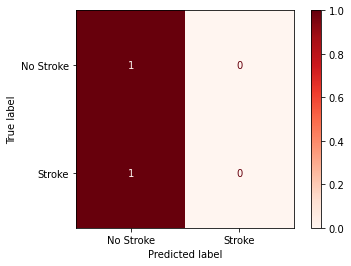

In [65]:
print('Logistic Regression Model with SMOTE Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_lr_smote_tuned, display_labels = labels, cmap = 'Reds', normalize = 'true');

  - The tuned Logistic Regression Model with SMOTE successfully classified 100% of the no stroke samples and 0% of the stroke samples (the same as the tuned Logistic Regression Model without SMOTE).

In [66]:
print('Logistic Regression Model with SMOTE Classification Report')
print(classification_report(y_test, test_preds_lr_smote_tuned))

Logistic Regression Model with SMOTE Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  - The tuned Logistic Regression Model with SMOTE was 95% accurate for making correct predictions on the test set (the same as the tuned Logistic Regression Model without SMOTE).
  - The tuned Logistic Regression Model with SMOTE was 95% sensitive and 100% specific for predicting the no stroke class (the same as the tuned Logistic Regression Model without SMOTE).
  - However, the tuned Logistic Regression Model with SMOTE was 0% sensitive and 0% specific for predicting the stroke class (the same as the tuned Logistic Regression Model without SMOTE).
  - Finally, the tuned Logistic Regression Model with SMOTE had f1-scores of 98% for the no stroke class and, again, 0% for the stroke class (the same as the tuned Logistic Regression Model without SMOTE).

Using SMOTE did not help the Logistic Regression Model predict the stroke class.

  - The tuned Random Forest Classifier with SMOTE model had the same accuracy for the test set.
  - The tuned Random Forest Classifier with SMOTE model had the same sensitivity and lower specificity for predicting the no stroke class.
  - However, the tuned Random Forest Classifier with SMOTE model was more sensitive and specific for predicting the stroke class.

Therefore, the tuned Random Forest Classifier with SMOTE model was the best so far for predicting strokes.

## LightGBM

In [67]:
#instantiate the model and the standard scaler
lgbm = LGBMClassifier(random_state=42)
scaler = StandardScaler()
#create a model pipeline
lgbm_pipe = make_pipeline(preprocessor, scaler, lgbm)
#fit the model pipeline on the training data
lgbm_pipe.fit(X_train, y_train)
#evaluate the model's performance
print(lgbm_pipe.score(X_train, y_train))
print(lgbm_pipe.score(X_test, y_test))

0.9953027139874739
0.945226917057903


#### Tuning hyperparameters using GridSearchCV

In [68]:
#choose hyperparameters for tuning
lgbm_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                   ('simpleimputer', SimpleImputer(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca28b0>)])),
  ('standardscaler', StandardScaler()),
  ('lgbmclassifier', LGBMClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>

In [69]:
#create a parameter grid dictionary
lgbm_param_grid = {'lgbmclassifier__num_leaves': [8, 21, 31, 100, 1000],
               'lgbmclassifier__max_depth': range(3, 12),
              'lgbmclassifier__learning_rate': [.01, 0.1, 0.2],
              'lgbmclassifier__class_weight': ['balanced', None]}           

In [70]:
#instantiate the GridSearchCV object
lgbm_grid_search = GridSearchCV(lgbm_pipe, lgbm_param_grid)

In [71]:
#fit the GridSearchCV object on the training data
lgbm_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                                                        ('simpleimputer',
                                                                         SimpleImputer(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca28b0>)])),
                                       ('standardscaler', StandardScaler()),
                                       ('lgbmclassifier',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'lgbmclassifier__class_weight': ['balanced', None],
                         'lgbmclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'lgbmclassifier__max_depth': range(3, 12),
                         'lgbmclassifier__num_leaves': [8, 21, 31, 100, 1000]})

In [72]:
#find the best parameters
print('Best LightGBMClassifier Parameters:')
print(lgbm_grid_search.best_params_)
best_lgbm = lgbm_grid_search.best_estimator_
print(f'Accuracy of best LGBMClassifier model is: {best_lgbm.score(X_test, y_test)}')

Best LightGBMClassifier Parameters:
{'lgbmclassifier__class_weight': None, 'lgbmclassifier__learning_rate': 0.01, 'lgbmclassifier__max_depth': 3, 'lgbmclassifier__num_leaves': 8}
Accuracy of best LGBMClassifier model is: 0.9514866979655712


### Final LightGBM Model Evaluation

In [73]:
#instantiate the tuned model
lgbm_tuned = LGBMClassifier(class_weight = None, learning_rate = 0.01, max_depth = 3, num_leaves = 8, random_state = 42)
#create the tuned model pipeline
lgbm_tuned_pipe = make_pipeline(preprocessor, scaler, lgbm_tuned)
#fit the tuned model pipeline on the training data
lgbm_tuned_pipe.fit(X_train, y_train)
#make predictions
train_preds_lgbm_tuned = lgbm_tuned_pipe.predict(X_train)
test_preds_lgbm_tuned = lgbm_tuned_pipe.predict(X_test)
#evaluate the model's performance
print(lgbm_tuned_pipe.score(X_train, y_train))
print(lgbm_tuned_pipe.score(X_test, y_test))

0.9512004175365344
0.9514866979655712


  - Tuning the LightGBMClassifier increased the accuracy on the test set.

LightGBM Confusion Matrix


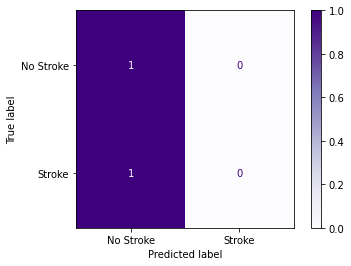

In [74]:
print('LightGBM Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_lgbm_tuned, display_labels = labels, cmap = 'Purples', normalize = 'true');

  - The tuned LightGBM successfully classified 100% of the no stroke samples but 0% of the stroke samples.

In [75]:
print('LightGBM Classification Report')
print(classification_report(y_test, test_preds_lgbm_tuned))

LightGBM Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  - The tuned LightGBM was 95% accurate for making correct predictions on the test set.
  - The tuned LightGBM was 95% sensitive and 100% specific for predicting the no stroke class.
  - However, the tuned LightGBM was 0% sensitive and 0% specific for predicting the stroke class.
  - The tuned LightGBM had f1-scores of 98% for the no stroke class, and, again, 0% for the stroke class.

The target class imbalance also limits this model's predictions of the stroke class.

#### LightGBM with SMOTE

In [76]:
#instantiate SMOTE and LGBMClassifier
smote = SMOTE(random_state=42)
lgbm_smote = LGBMClassifier(random_state=42)
#create a model pipeline
lgbm_smote_pipe = make_sampler_pipeline(preprocessor, scaler, smote, lgbm_smote)
#fit the model pipeline on the training data
lgbm_smote_pipe.fit(X_train, y_train)
#evaluate the model's performance
print(lgbm_smote_pipe.score(X_train, y_train))
print(lgbm_smote_pipe.score(X_test, y_test))

0.9770354906054279
0.9225352112676056


#### Tuning hyperparameters using GridSearchCV

In [77]:
#choose hyperparameters for tuning
lgbm_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                   ('simpleimputer', SimpleImputer(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca28b0>)])),
  ('standardscaler', StandardScaler()),
  ('smote', SMOTE(random_state=42)),
  ('lgbmclassifier', LGBMClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_colu

In [78]:
#create a parameter grid dictionary
lgbm_smote_param_grid = {'lgbmclassifier__num_leaves': [8, 21, 31, 100, 1000],
               'lgbmclassifier__max_depth': range(3, 12),
              'lgbmclassifier__learning_rate': [.01, 0.1, 0.2],
              'lgbmclassifier__class_weight': ['balanced', None]}    

In [79]:
#instantiate the GridSearchCV object
lgbm_smote_grid_search = GridSearchCV(lgbm_smote_pipe, lgbm_smote_param_grid)

In [80]:
#fit the GridSearchCV object on the training data
lgbm_smote_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca2700>),
                                                                        ('simpleimputer',
                                                                         SimpleImputer(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26faca28b0>)])),
                                       ('standardscaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('lgbmclassifier',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'lgbmclassifier__class_weight': ['balanced', None],
                         'lgbmclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'lgbmclassifier__max_depth': range(3, 12),
                         'lgbmclassifier__num_leaves': [8, 21, 31, 100, 1000]})

In [81]:
#find the best parameters
print('Best LightGBMClassifier with SMOTE Parameters:')
print(lgbm_smote_grid_search.best_params_)
best_lgbm_smote = lgbm_smote_grid_search.best_estimator_
print(f'Accuracy of best LGBMClassifier model with SMOTE is: {best_lgbm_smote.score(X_test, y_test)}')

Best LightGBMClassifier with SMOTE Parameters:
{'lgbmclassifier__class_weight': 'balanced', 'lgbmclassifier__learning_rate': 0.2, 'lgbmclassifier__max_depth': 11, 'lgbmclassifier__num_leaves': 31}
Accuracy of best LGBMClassifier model with SMOTE is: 0.9287949921752738


### Final LightGBM Model with SMOTE Evaluation

In [82]:
#instantiate the tuned model
lgbm_smote_tuned = LGBMClassifier(class_weight = 'balanced', learning_rate = 0.2, max_depth = 11, num_leaves = 31, random_state = 42)
#create the tuned model pipeline
lgbm_smote_tuned_pipe = make_sampler_pipeline(preprocessor, scaler, smote, lgbm_smote_tuned)
#fit the tuned model pipeline on the training data
lgbm_smote_tuned_pipe.fit(X_train, y_train)
#make predictions
train_preds_lgbm_smote_tuned = lgbm_smote_tuned_pipe.predict(X_train)
test_preds_lgbm_smote_tuned = lgbm_smote_tuned_pipe.predict(X_test)
#evaluate the model's performance
print(lgbm_smote_tuned_pipe.score(X_train, y_train))
print(lgbm_smote_tuned_pipe.score(X_test, y_test))

0.997651356993737
0.9287949921752738


  - Tuning the LightGBM with SMOTE increased the accuracy on the test set.

LightGBM with SMOTE Confusion Matrix


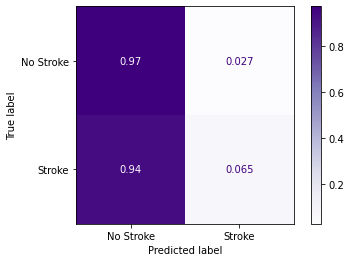

In [83]:
print('LightGBM with SMOTE Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_lgbm_smote_tuned, display_labels = labels, cmap = 'Purples', normalize = 'true');

  - The tuned LightGBM with SMOTE successfully classified 97% of the no stroke samples (less than the tuned LightGBM without SMOTE) and 6.5% of the stroke samples (more than the tuned LightGBM without SMOTE).

In [84]:
print('LightGBM with SMOTE Classification Report')
print(classification_report(y_test, test_preds_lgbm_smote_tuned))

LightGBM with SMOTE Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1216
           1       0.11      0.06      0.08        62

    accuracy                           0.93      1278
   macro avg       0.53      0.52      0.52      1278
weighted avg       0.91      0.93      0.92      1278



  - The tuned LightGBM with SMOTE was 93% accurate for making correct predictions on the test set (lower than the tuned LightGBM without SMOTE).
  - The tuned LightGBM with SMOTE was 95% sensitive (the same as the tuned LightGBM without SMOTE) and 97% specific for predicting the no stroke class (less than the tuned LightGBM without SMOTE).
  - The tuned LightGBM with SMOTE was 11% sensitive and 6% specific for predicting the stroke class (higher than the tuned LightGBM without SMOTE).
  - The tuned LightGBM had f1-scores of 96% for the no stroke class (lower than the tuned LightGBM without SMOTE) and 8% for the stroke class (higher than the tuned LightGBM without SMOTE).

Using SMOTE helped the LightGBM predict the stroke class.

  - The tuned Random Forest Classifier with SMOTE had higher accuracy for making correct predictions on the test set.
  - The tuned LightGBM with SMOTE had the same sensitivity for predicting the no stroke class.  However, the tuned Random Forest Classifier with SMOTE had higher specificity for predicting the no stroke class.  
**The tuned LightGBM with SMOTE had more false positives.**
  - The tuned Random Forest Classifier with SMOTE had higher sensitivity and specificity for predicting the stroke class.  
**The tuned Random Forest Classifier with SMOTE had more false negatives.**
  - The tuned Random Forest Classifier with SMOTE had higher f1-scores for the no stroke class and the same f1-scores for the stroke class.

Because of the class imbalance, the final model must predict well for the stroke class--the tuned LightGBM with SMOTE was better at predicting the stroke class.

Because of the high cost of false negatives (predicting no stroke when, in fact, there will be a stroke), these errors must be reduced--the tuned LightGBM with SMOTE had a lower false negative rate.

## Principal Component Analysis

### Prepare the data

#### Create a copy of the data

In [85]:
pca_df = df.copy()

#### Separate the data into the features matrix (X) and target vector (y)

In [86]:
X = pca_df.drop(columns = 'stroke')
y = pca_df['stroke']

#### Train test split the data (model validation)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

#### Preprocessor

In [88]:
#instantiate the transformers to impute missing values and one-hot encode the categorical data
mean_imputer = SimpleImputer(strategy = 'mean')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
#create columnselectors for the numeric and categorical data
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
#combine the pipelines and columnselectors into tuples for the columntransformer
cat_tuple = (ohe, cat_selector)
num_tuple = (mean_imputer, num_selector)
#create the preprocessing columntransformer
preprocessor2 = make_column_transformer(cat_tuple, num_tuple, remainder='drop')
preprocessor2

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fab698b0>),
                                ('simpleimputer', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fab69bb0>)])

#### Instantiate StandardScaler, SMOTE, and PCA

In [89]:
scaler = StandardScaler()
smote = SMOTE(random_state=42)
pca = PCA(n_components = .95, random_state = 42)

### LightGBM with SMOTE and PCA

In [90]:
#put the PCA pipeline in a model pipeline
lgbm_smote_pca = LGBMClassifier(random_state=42)
lgbm_smote_pca_pipe = make_sampler_pipeline(preprocessor2, scaler, smote, lgbm_smote_pca)
#fit the model pipeline on the training data
lgbm_smote_pca_pipe.fit(X_train, y_train)
#evaluate the model's performance
print(lgbm_smote_pca_pipe.score(X_train, y_train))
print(lgbm_smote_pca_pipe.score(X_test, y_test))

0.9770354906054279
0.9225352112676056


#### Tuning hyperparameters using GridSearchCV and pipelines

In [91]:
#choose hyperparameters for tuning
lgbm_smote_pca_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fab698b0>),
                                   ('simpleimputer', SimpleImputer(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fab69bb0>)])),
  ('standardscaler', StandardScaler()),
  ('smote', SMOTE(random_state=42)),
  ('lgbmclassifier', LGBMClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_colu

In [92]:
#create a parameter grid dictionary
lgbm_smote_pca_param_grid = {'lgbmclassifier__num_leaves': [8, 21, 31, 100, 1000],
               'lgbmclassifier__max_depth': range(3, 12),
              'lgbmclassifier__learning_rate': [.01, 0.1, 0.2],
              'lgbmclassifier__class_weight': ['balanced', None]}  

In [93]:
#instantiate the GridSearchCV object
lgbm_smote_pca_grid_search = GridSearchCV(lgbm_smote_pca_pipe, lgbm_smote_pca_param_grid)

In [94]:
#fit the GridSearchCV object on the training data
lgbm_smote_pca_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fab698b0>),
                                                                        ('simpleimputer',
                                                                         SimpleImputer(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fab69bb0>)])),
                                       ('standardscaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('lgbmclassifier',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'lgbmclassifier__class_weight': ['balanced', None],
                         'lgbmclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'lgbmclassifier__max_depth': range(3, 12),
                         'lgbmclassifier__num_leaves': [8, 21, 31, 100, 1000]})

In [95]:
#find the best parameters
print('Best LightGBMClassifier with SMOTE and PCA Parameters:')
print(lgbm_smote_pca_grid_search.best_params_)
best_lgbm_smote_pca = lgbm_smote_pca_grid_search.best_estimator_
print(f'Accuracy of best LGBMClassifier with SMOTE and PCA model is: {best_lgbm_smote_pca.score(X_test, y_test)}')

Best LightGBMClassifier with SMOTE and PCA Parameters:
{'lgbmclassifier__class_weight': 'balanced', 'lgbmclassifier__learning_rate': 0.2, 'lgbmclassifier__max_depth': 11, 'lgbmclassifier__num_leaves': 31}
Accuracy of best LGBMClassifier with SMOTE and PCA model is: 0.9287949921752738


#### LightGBM with SMOTE and PCA Model Evaluation

In [96]:
#instantiate the new scaler and the new PCA
scaler2 = StandardScaler()
smote2 = SMOTE(random_state=42)
pca2 = PCA(n_components = .95, random_state = 42)
#instantiate the tuned model
lgbm_smote_pca_tuned = LGBMClassifier(class_weight = 'balanced', learning_rate = 0.2, max_depth = 11, num_leaves = 31, random_state = 42)
#create the tuned model pipeline
lgbm_smote_pca_tuned_pipe = make_sampler_pipeline(preprocessor2, scaler2, smote2, lgbm_smote_pca_tuned)
#fit the tuned model pipeline on the training data
lgbm_smote_pca_tuned_pipe.fit(X_train, y_train)
#make predictions
train_preds_lgbm_smote_pca_tuned = lgbm_smote_pca_tuned_pipe.predict(X_train)
test_preds_lgbm_smote_pca_tuned = lgbm_smote_pca_tuned_pipe.predict(X_test)
#evaluate the model's performance
print(lgbm_smote_pca_tuned_pipe.score(X_train, y_train))
print(lgbm_smote_pca_tuned_pipe.score(X_test, y_test))

0.997651356993737
0.9287949921752738


  - Tuning the LightGBMClassifier with SMOTE and PCA increased the accuracy on the test set.

Tuned LightGBM with SMOTE and PCA Confusion Matrix


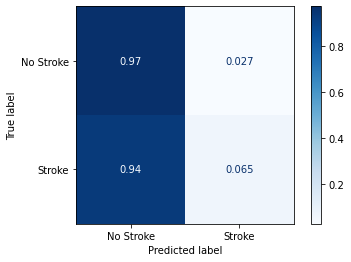

In [97]:
print('Tuned LightGBM with SMOTE and PCA Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_lgbm_smote_pca_tuned, display_labels = labels, cmap = 'Blues', normalize = 'true');

  - The tuned LightGBM with SMOTE and PCA successfully classified 97% of the no stroke samples and 6.5% of the stroke samples (the same as the tuned LightGBM with SMOTE without PCA).

In [98]:
print('Tuned LightGBM with PCA Classification Report')
print(classification_report(y_test, test_preds_lgbm_smote_pca_tuned))

Tuned LightGBM with PCA Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1216
           1       0.11      0.06      0.08        62

    accuracy                           0.93      1278
   macro avg       0.53      0.52      0.52      1278
weighted avg       0.91      0.93      0.92      1278



  - The tuned LightGBM with SMOTE and PCA was 93% accurate for making correct predictions on the test set (the same as the tuned LightGBM with SMOTE without PCA).
  - The tuned LightGBM with SMOTE and PCA was 95% sensitive and 97% specific for predicting the no stroke class (the same as the tuned LightGBM with SMOTE without PCA).  
  - The tuned LightGBM with SMOTE and PCA was 11% sensitive and 6% specific for predicting the stroke class (the same as the tuned LightGBM with SMOTE without PCA).  
  - The tuned LightGBM with SMOTE and PCA had f1-scores of 96% for the no stroke class and 8% for the stroke class (the same as the tuned LightGBM with SMOTE without PCA) ).

  - The tuned LightGBM with SMOTE had the same accuracy for making correct predictions on the test set regardless of PCA.
  - The tuned LightGBM with SMOTE had the same sensitivity and specificity for predicting the no stroke class regardless of PCA.  
**The tuned LightGBM with SMOTE had the same false positive rate regardless of PCA.**
  - The tuned LightGBM with SMOTE had the same sensitivity and specificity for predicting the stroke class regardless of PCA.  
**The tuned LightGBM with SMOTE had the same false negative rate regardless of PCA.**
  - The tuned LightGBM with SMOTe had the same f1-scores for the no stroke class and for the stroke class regardless of PCA.

Because of the class imbalance, the final model must predict well for the stroke class--using PCA did not help LightGBM with SMOTE predict the stroke class.

Because of the high cost of false negatives (predicting no stroke when, in fact, there will be a stroke), these errors must be reduced--using PCA did not help LightGBM with SMOTE reduce the false negative rate.

## Feature Engineering

### Prepare the data

#### Create a copy of the data

In [99]:
fe_df = df.copy()

In [100]:
fe_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Feature Engineering

Delete gender and Residence_type columns:  
Multivariate visualizations showed that there was no relationship between the gender of the patient and strokes.  They also showed that there is no difference in urban vs rural residences and strokes.  Eliminating these data might help the model better predict strokes.

In [101]:
fe_df.drop(columns = ['gender', 'Residence_type'], inplace=True)
fe_df.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,
9046,67.0,0,1,Yes,Private,228.69,36.6,formerly smoked,1
51676,61.0,0,0,Yes,Self-employed,202.21,NaN,never smoked,1
31112,80.0,0,1,Yes,Private,105.92,32.5,never smoked,1
60182,49.0,0,0,Yes,Private,171.23,34.4,smokes,1
1665,79.0,1,0,Yes,Self-employed,174.12,24.0,never smoked,1


Combine ever_married and work_type columns:
Multivariate visualizations showed that both of these features increased strokes.  However, there are other reasons (besides the risk of stroke) that affect patients' choices for marriage and work.  Combining these data might help the model better predict strokes, based on factors more related to the risk of stroke.

In [102]:
fe_df['MarriageWork'] = fe_df['ever_married'] + fe_df['work_type']
fe_df.drop(columns=['ever_married','work_type'], inplace=True)
fe_df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,MarriageWork
id,,,,,,,,
9046,67.0,0,1,228.69,36.6,formerly smoked,1,YesPrivate
51676,61.0,0,0,202.21,NaN,never smoked,1,YesSelf-employed
31112,80.0,0,1,105.92,32.5,never smoked,1,YesPrivate
60182,49.0,0,0,171.23,34.4,smokes,1,YesPrivate
1665,79.0,1,0,174.12,24.0,never smoked,1,YesSelf-employed


Change numeric medical characteristics to categorical medical characteristics because some of the medical characteristics are already categorical.

In [103]:
def bmi_bin(bmi):
  if bmi < 18.5:
    return 'underweight'
  elif 18.5 <= bmi <= 24.9:
    return 'healthy weight'
  elif 25.0 <= bmi <= 29.9:
    return 'overweight'
  else:
    return 'obese'
fe_df['bmi'] = fe_df['bmi'].apply(bmi_bin)
display(fe_df.head())

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,MarriageWork
id,,,,,,,,
9046,67.0,0,1,228.69,obese,formerly smoked,1,YesPrivate
51676,61.0,0,0,202.21,obese,never smoked,1,YesSelf-employed
31112,80.0,0,1,105.92,obese,never smoked,1,YesPrivate
60182,49.0,0,0,171.23,obese,smokes,1,YesPrivate
1665,79.0,1,0,174.12,healthy weight,never smoked,1,YesSelf-employed


In [104]:
def glucose_bin(x):
  if 126 < x:
    return 'diabetes'
  elif 100 <= x <= 125:
    return 'prediabetes'
  else:
    return 'normal'
fe_df['avg_glucose_level'] = fe_df['avg_glucose_level'].apply(glucose_bin)
fe_df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,MarriageWork
id,,,,,,,,
9046,67.0,0,1,diabetes,obese,formerly smoked,1,YesPrivate
51676,61.0,0,0,diabetes,obese,never smoked,1,YesSelf-employed
31112,80.0,0,1,prediabetes,obese,never smoked,1,YesPrivate
60182,49.0,0,0,diabetes,obese,smokes,1,YesPrivate
1665,79.0,1,0,diabetes,healthy weight,never smoked,1,YesSelf-employed


#### Separate the data into the features matrix (X) and target vector (y)

In [105]:
X = fe_df.drop(columns = 'stroke')
y = fe_df['stroke']

#### Train test split the data (model validation)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

#### Preprocessor

In [107]:
#instantiate the transformers to impute missing values and one-hot encode the categorical data
freq_imputer = SimpleImputer(strategy = 'most_frequent')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
#create columnselectors for the numeric and categorical data
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
#combine the pipelines and columnselectors into tuples for the columntransformer
cat_tuple = (ohe, cat_selector)
num_tuple = (freq_imputer, num_selector)
#create the preprocessing columntransformer
preprocessor3 = make_column_transformer(cat_tuple, num_tuple, remainder='drop')
preprocessor3

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fad4db20>),
                                ('simpleimputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fad4dfd0>)])

### LightGBM with SMOTE on engineered features

In [108]:
#instantiate the model, the standard scaler, and smote
lgbm_fe = LGBMClassifier(random_state=42)
scaler = StandardScaler()
smote = SMOTE(random_state=42)
#create a model pipeline
lgbm_fe_pipe = make_sampler_pipeline(preprocessor3, scaler, smote, lgbm_fe)
#fit the model pipeline on the training data
lgbm_fe_pipe.fit(X_train, y_train)
#evaluate the model's performance
print(lgbm_fe_pipe.score(X_train, y_train))
print(lgbm_fe_pipe.score(X_test, y_test))

0.9577244258872651
0.9264475743348983


#### Tuning hyperparameters using GridSearchCV

In [109]:
#choose hyperparameters for tuning
lgbm_fe_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fad4db20>),
                                   ('simpleimputer',
                                    SimpleImputer(strategy='most_frequent'),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fad4dfd0>)])),
  ('standardscaler', StandardScaler()),
  ('smote', SMOTE(random_state=42)),
  ('lgbmclassifier', LGBMClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                    

In [110]:
#create a parameter grid dictionary
lgbm_fe_param_grid = {'lgbmclassifier__num_leaves': [8, 21, 31, 100, 1000],
               'lgbmclassifier__max_depth': range(3, 12),
              'lgbmclassifier__learning_rate': [.01, 0.1, 0.2],
              'lgbmclassifier__class_weight': ['balanced', None]}  

In [111]:
#instantiate the GridSearchCV object
lgbm_fe_grid_search = GridSearchCV(lgbm_fe_pipe, lgbm_fe_param_grid)

In [112]:
#fit the GridSearchCV object on the training data
lgbm_fe_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f26fad4db20>),
                                                                        ('simpleimputer',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         <sklearn.compose._column_transformer.make_column_s...tor object at 0x7f26fad4dfd0>)])),
                                       ('standardscaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('lgbmclassifier',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'lgbmclassifier__class_weight': ['balanced', None],
                         'lgbmclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'lgbmclassifier__max_depth': range(3, 12),
                         'lgbmclassifier__num_leaves': [8, 21, 31, 100, 1000]})

In [113]:
#find the best parameters
print('Best LightGBMClassifier with SMOTE on engineered features Parameters:')
print(lgbm_fe_grid_search.best_params_)
best_lgbm_fe = lgbm_fe_grid_search.best_estimator_
print(f'Accuracy of best LGBMClassifier model with SMOTE on engineered features is: {best_lgbm_fe.score(X_test, y_test)}')

Best LightGBMClassifier with SMOTE on engineered features Parameters:
{'lgbmclassifier__class_weight': 'balanced', 'lgbmclassifier__learning_rate': 0.2, 'lgbmclassifier__max_depth': 10, 'lgbmclassifier__num_leaves': 21}
Accuracy of best LGBMClassifier model with SMOTE on engineered features is: 0.9334898278560251


### LightGBM with SMOTE on Engineered Features Model Evaluation

In [114]:
#instantiate the tuned model
lgbm_fe_tuned = LGBMClassifier(class_weight = 'balanced', learning_rate = 0.2, max_depth = 10, num_leaves = 21, random_state = 42)
#create the tuned model pipeline
lgbm_fe_tuned_pipe = make_sampler_pipeline(preprocessor3, scaler, smote, lgbm_fe_tuned)
#fit the tuned model pipeline on the training data
lgbm_fe_tuned_pipe.fit(X_train, y_train)
#make predictions
train_preds_lgbm_fe_tuned = lgbm_fe_tuned_pipe.predict(X_train)
test_preds_lgbm_fe_tuned = lgbm_fe_tuned_pipe.predict(X_test)
#evaluate the model's performance
print(lgbm_fe_tuned_pipe.score(X_train, y_train))
print(lgbm_fe_tuned_pipe.score(X_test, y_test))

0.968945720250522
0.9334898278560251


  - Tuning the LightGBMClassifier with SMOTE on Engineered Features increased the accuracy on the test set.

LightGBM with SMOTE on Engineered Features Confusion Matrix


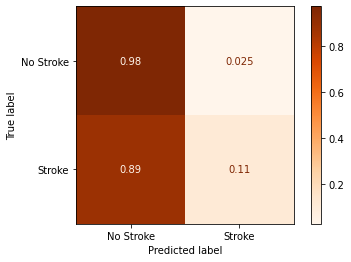

In [115]:
print('LightGBM with SMOTE on Engineered Features Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_lgbm_fe_tuned, display_labels = labels, cmap = 'Oranges', normalize = 'true');

  - The tuned LightGBM with SMOTE on Engineered Features successfully classified 98% of the no stroke samples and 11% of the stroke samples (higher than the tuned LightGBM with SMOTE).

In [116]:
print('LightGBM with SMOTE on Engineered Features Classification Report')
print(classification_report(y_test, test_preds_lgbm_fe_tuned))

LightGBM with SMOTE on Engineered Features Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1216
           1       0.19      0.11      0.14        62

    accuracy                           0.93      1278
   macro avg       0.57      0.54      0.55      1278
weighted avg       0.92      0.93      0.93      1278



  - The tuned LightGBM with SMOTE on Engineered Features was 93% accurate for making correct predictions on the test set (the same as the tuned LightGBM with SMOTE on the original features).
  - The tuned LightGBM with SMOTE on Engineered Features was 96% sensitive and 98% specific for predicting the no stroke class (higher than the tuned LightGBM with SMOTE on the original features).
  - The tuned LightGBM with SMOTE on Engineered Features was 19% sensitive and 11% sensitive for predicting the stroke class (higher than the tuned LightGBM with SMOTE on the original features).
  - The tuned LightGBM with SMOTE on Engineered Features had f1-scores of 97% on the no stroke class and 14% on the stroke class (higher than the tuned LightGBM with SMOTE on the original features).

Using feature engineering helped the LightGBM with SMOTE predict the stroke class.



  - The tuned LightGBM with SMOTE had the same accuracy for making correct predictions on the test set for the original features and for the engineered features.
  - The tuned LightGBM with SMOTE was more sensitive and specific for predicting the no stroke class with the engineered features.
  - The tuned LightGBM with SMOTE was more sensitive and specific for predicting the stroke class with the engineered features.
  - The tuned LightGBM with SMOTE had fewer false positives and false negatives on the engineered features. 

Because of the class imbalance, the final model must predict well for the stroke class--feature engineering helped LightGBM with SMOTE predict the stroke class.  The improvement was 8% for precision and 5% for recall. 

Because of the high cost of false negatives (predicting no stroke when, in fact, there will be a stroke), these errors must be reduced--feature engineering did help LightGBM with SMOTE reduce the false negative rate by 5%.  It also helped LightGBM with SMOTE reduce the false positive rate by 0.2%.

# A tuned LightGBM with SMOTE made the best predictions for the stroke class while limiting the false negative rate.  Feature engineering improved those predictions even further.

  - The first problem with the dataset was the missing data from the bmi feature--it required imputation for machine learning, which introduced error.

  - The next, and the primary problem, with the dataset was that the target classes were severely imbalanced (95.13% of the samples did not have a stroke and 4.87% of the samples had a stroke).  It required tuning the class balance for all models, with little improvement.  It further required the use of SMOTE, which creates new, synthetic data that is very similar to the data in the minority class--the use of SMOTE improved the model's predictions but also introduced error.

  - The third problem with the dataset was the inconsistent specificity of the datatypes--some medical data was provided numerically but some numeric medical data (specifically heart disease and hypertension) was already binned into binary categories.  Information with predictive value was already lost when those values were binned.

# The tuned LightGBM with SMOTE is not ready for real-world data with real-world consequences.
The predictive models used are powerful tools--additional tuning and data manipulations increased their power even further.  However, the best model was not even very good at predicting the stroke class--it only achieved 19% precision and 11% recall for the stroke class.  Plus, it had an 89% rate of false negatives--that means that 89% of people who will have a stroke were actually predicted to not have a stroke!  

New data with more specific medical information will help create a new predictive model that will successfully predict strokes.  Once that is achieved, predictive modeling can then be employed to improve stroke recovery, too.